<h2>Classical helium atom</h2>

Lars Schuster           13.10.2022

Suppose the electrons of a helium atom are confined to a 2D plane and only electromagnetic forces play a role in their trajectories. Setting the units so that all constants become one the atom can be moddled by the following differential equations:

$\ddot{\vec{r_1}} = -2 \frac{\vec{r_1}}{r_1^3} + \frac{\vec{r_1} - \vec{r_2}}{r_{12}^3}$

$\ddot{\vec{r_2}} = -2 \frac{\vec{r_2}}{r_2^3} + \frac{\vec{r_2} - \vec{r_1}}{r_{12}^3}$

To get first order differential equations velocity can be expressed as a the time derivative of position and accleration as the time derivative of velocity.

$\vec{v_1} = \dot{\vec{r_1}}$

$\vec{v_2} = \dot{\vec{r_2}}$

$\dot{\vec{v_1}} =  -2 \frac{\vec{r_1}}{r_1^3} + \frac{\vec{r_1} - \vec{r_2}}{r_{12}^3}$

$\dot{\vec{v_2}} = -2 \frac{\vec{r_2}}{r_2^3} + \frac{\vec{r_2} - \vec{r_1}}{r_{12}^3}$

Theses equations can numerically be solved with the Euler Scheme or the Euler-Richardson Algorithm utilizing Taylor expansion.


The first function needed is to calculate the new state (described position,velocity and acceleration) of the two electrons from one iteration to the next. 
This function utilizes the Euler Scheme.

The arguments are the 2D-vectors describing the current state for each particle this inclues the position, velocity and the acceleration (eg. for the first electron p1,v1,a1). The last argument is dt is the timestep in seconds.

In [19]:
from locale import ABDAY_1
from IPython import display
from matplotlib import pyplot as plt
from mpl_toolkits import mplot3d
import numpy as np

def euler(p1, p2, v1, v2, a1, a2, dt):
    p1n = p1 + v1*dt
    p2n = p2 + v2*dt

    v1n = v1 + a1*dt
    v2n = v2 + a2*dt

    p12n = p1n - p2n
    a1n = p1n * -2 * (1/np.linalg.norm(p1n)**3) + \
        (p1n-p2n)/(np.linalg.norm(p12n)**3)
    a2n = p2n * -2 * (1/np.linalg.norm(p2n)**3) + \
        (p2n-p1n)/(np.linalg.norm(p12n)**3)
    return [p1n, p2n, v1n, v2n, a1n, a2n]

The second function implements the same functionality as the first one. The difference is that the new state is calculated using the euler richardson method.
The arguments are identical.

In [20]:
def eulerrich(p1, p2, v1, v2, a1, a2, dt):
    v1m = v1 + 0.5 * a1*dt
    v2m = v2 + 0.5 * a2*dt

    p1m = p1 + 0.5 * v1*dt
    p2m = p2 + 0.5 * v2*dt

    p12m = p1m - p2m
    a1m = p1m * -2 * (1/np.linalg.norm(p1m)**3) + \
        (p1m-p2m)/(np.linalg.norm(p12m)**3)
    a2m = p2m * -2 * (1/np.linalg.norm(p2m)**3) + \
        (p2m-p1m)/(np.linalg.norm(p12m)**3)

    p1n = p1 + v1m*dt
    p2n = p2 + v2m*dt

    v1n = v1 + a1m*dt
    v2n = v2 + a2m*dt

    p12n = p1n - p2n
    a1n = p1n * -2 * (1/np.linalg.norm(p1n)**3) + \
        (p1n-p2n)/(np.linalg.norm(p12n)**3)
    a2n = p2n * -2 * (1/np.linalg.norm(p2n)**3) + \
        (p2n-p1n)/(np.linalg.norm(p12n)**3)
    return [p1n, p2n, v1n, v2n, a1n, a2n]


To implement the timestep control the difference in energy between two states has to be calculated. 
To do this the function comp Energy computes the Energy of a state described by position and velocity vectors.

Since the units are choosen so that all constants equal 1 the total energy can be expressed as follows:

$E_{tot} = E_{kin_1} +E_{kin_2} + E_{pot_1} + E_{pot_2} \\
E_{tot} = \frac{v_1^2}{2} +\frac{v_2^2}{2}  - \frac{2}{r_1} - \frac{2}{r_2} + \frac{2}{r_{12}}$ 

The function returns the total Energy as well as the components.

In [21]:
def compEnergy(p1, p2, v1, v2):
    E_kin = (1/2)*np.linalg.norm(v1)**2 + (1/2)*np.linalg.norm(v2)**2
    E_pot = -2/np.linalg.norm(p1) + 1/np.linalg.norm(p1-p2) + \
        -2/np.linalg.norm(p2) + 1/np.linalg.norm(p1-p2)
    Energy = E_kin + E_pot
    return [Energy, E_kin , E_pot]



Finally the computation of the orbits is made in the helium function.

The arguments are the components of the vectors of initial position and velocity for both the particles(positions expressed as x_1 for x coordinate of particle 1 similarliy for the other vectors).<br>
The timestep dt is important if time control is not active.<br>
The parameter n represents the number of iterations(eg. new states calculated).<br>
The boolean t_crtl turns on timestep-control when True.<br>
Newstate is the function used to compute the next time step of the two particles.<br>
(This also implies what method is used simple Euler Scheme or Euler-Richardson)<br>

First the function will set all the arrays and initial values.
The for -loop will create a new state for every iteration starting at 1 since the inital conditions are alerady given.
If the time step control is active the while loop will ensure that the time step is sufficiently small considering the conservation of enery.
If the timestep is too large the function will disregard the results and recompute the function with half th timestep.
If the timestep is too small the timestep will be doubled for the next iteration.
The bounds describing if change in Energy is too small or too large were varied to find $10^{-4}$ as upper bound and $10^{-5}$ as the lower bound.
Increasing the value would decrease accuracy but also the computational cost.
Deacreasing the bounds would have opposite effect.

The helium-function will return a list containing arrays of the positions of the electrons, the number of iterations, the timestep it used and the times corresponding to the positons.

In [22]:
def helium(x_1, y_1, x_2, y_2, vx_1, vy_1, vx_2, vy_2, dt, n , t_crtl, newstate):
    r1, r2, Es = np.zeros((n, 2)), np.zeros((n, 2)), np.zeros((n,3))
    dE, ts = 0, np.zeros(n)

    r1[0], r2[0] = np.array([x_1, y_1]), np.array([x_2, y_2])
    v1, v2 = np.array([vx_1, vy_1]), np.array([vx_2, vy_2])

    a1 = r1[0] * -2 * (1/np.linalg.norm(r1[0])**3) + \
        (r1[0]-r2[0])/(np.linalg.norm(r1[0]-r2[0])**3)
    a2 = r2[0] * -2 * (1/np.linalg.norm(r2[0])**3) + \
        (r2[0]-r1[0])/(np.linalg.norm(r1[0]-r2[0])**3)
    E = compEnergy(r1[0],r2[0],v1,v2)
    Es[0] = np.array(E)
    nE = 0

    for i in  range(1,n):
        nstate = newstate(r1[i-1], r2[i-1], v1, v2, a1, a2, dt)
        nE = compEnergy(nstate[0], nstate[1], nstate[2], nstate[3])
        dE = np.abs(E[0]-nE[0])
        while (t_crtl and (dE > 10**-4)):
            dt = dt/2
            nstate = newstate(r1[i-1], r2[i-1], v1, v2, a1, a2, dt)
            nE = compEnergy(nstate[0], nstate[1], nstate[2], nstate[3])
            dE = np.abs(E[0]-nE[0])
        if (t_crtl and (dE < 10**-5)):
            dt = dt*2

        E = nE
        r1[i] = nstate[0]
        r2[i] = nstate[1]
        v1 = nstate[2]
        v2 = nstate[3]
        a1 = nstate[4]
        a2 = nstate[5]
        ts[i] = ts[i-1] + dt
        Es[i] = np.array(E)

    return [r1, r2, n, dt, ts, Es]

The following functions can be used to plot the output data of the helium nucleus.
The first one will create a two dimensional plot that disregards time and shows the trajectory over the given interval.

The second function will create a three dimensional plot which shows the position as a graph of time.

The third function plots all the energies as graphs of time.

In [23]:
def plot2(x1, y1, x2, y2, label1, label2):
    plt.title("Postions of the particles")
    plt.xlabel('x')
    plt.ylabel('y')
    plt.plot(x1, y1, label=label1, c="orange")
    plt.plot(x2, y2, label=label2, c="blue")
    plt.plot(x2[0], y2[0], "o",  c="blue")
    plt.plot(x1[0], y1[0], "o",  c="orange")
    plt.plot(0,0,"o", label="Nucleus", c="red")
    plt.grid()
    plt.axis("scaled")
    plt.legend(loc=1)
    plt.tight_layout()
    plt.show()
    plt.close()

def plot3d(x1, y1, x2, y2, ts ,n,  label1, label2, label3):
    fig = plt.figure()
    ax = plt.axes(projection="3d")
    ax.plot(np.zeros(n), np.zeros(n), ts, label=label3,linewidth= 3,alpha= 1, c="red")
    ax.plot(x1, y1, ts, label=label1 , alpha=0.75,c="orange")
    ax.plot(x2, y2, ts, label=label2, alpha=0.75,c="blue")
    ax.set_xlabel("x")
    ax.set_ylabel("y")
    ax.set_zlabel("t in s")
    plt.legend(loc=1)
    plt.show()
    plt.close()

    

def plotE(E_tot, E_kin, E_pot, ts):
    plt.title("Energies in the System")
    plt.xlabel('Time in s')
    plt.ylabel('Energy')
    plt.plot(ts, E_tot, label="$E_{tot}$", c="orange")
    plt.plot(ts, E_kin, label="$E_{kin}$", c="blue")
    plt.plot(ts, E_pot, label="$E_{pot}$",  c="red")
    plt.grid()
    plt.legend(loc=1)
    plt.tight_layout()
    plt.show()
    plt.close()

Running the code with the inital  values of 
$\vec{r_1} = (2, 0), \vec{r_2} = (−1, 0), \vec{v_1} = (0, 0.95), \vec{v_2} = (0, −1)$ we can observe the electrons orbiting the nucleues in a way similar to two planets orbiting a heavy sun. The orbits are eliptical and more or less independent from one another.
It is more clear if the algorithm is run with a million iterations but the time to compute it may be a couple of minutes.

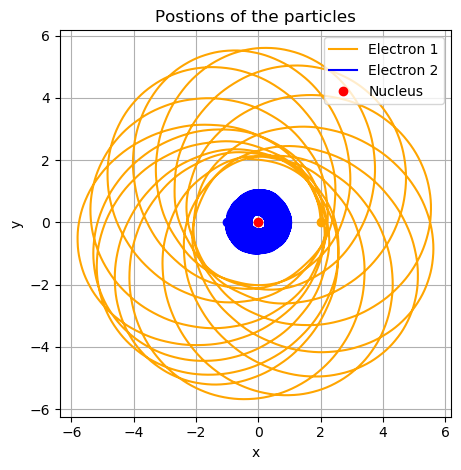

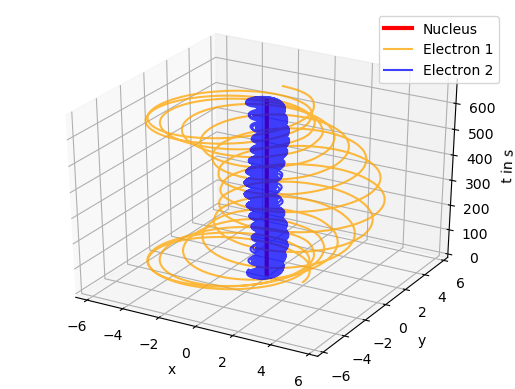

In [24]:
data = helium(2, 0, -1, 0, 0, .95, 0, -1, .1, 1000000, True, eulerrich)
plot2(data[0][:, 0], data[0][:, 1], data[1][:, 0],
      data[1][:, 1], "Electron 1", "Electron 2")

plot3d(data[0][:, 0], data[0][:, 1], data[1][:, 0],
       data[1][:, 1], data[4],data[2], "Electron 1", "Electron 2", "Nucleus")

To test the program an analytical solution to the three body problem is considered. 
The two electrons are opposite of one another with the nucleus in the middle.
The forces and acceleration vecors on the particles will be paralell and they can be treated as a single particle orbiting another heavier , non-moving particle.

If the electrons are one unit away form the nucleus they are accelrated towards it with a magnitude of 1.75 units/s.

$a_1 = -a_2 =-2 \frac{1}{1^3} + \frac{1 -(-1)}{2^3}\\
a_1 = 1.75 \frac{units}{s}$

To achieve a stable orbit the centripetal acceleration and the acceleration due to the Coulomb's Force must be equal:

$a_c = a_Q$

$1.75 = rv^2$
$=> v = \sqrt{1.75}$

To keep the orbit stalbe the two electrons should rotate in the same direction so their inital velocites are opposite.

The state would be $\vec{r_1} = (-1, 0)$, $\vec{r_1} = (1, 0)$, $\vec{v_1} = (0, \sqrt{1.75})$, $\vec{v_2} = (0, -\sqrt{1.75})$

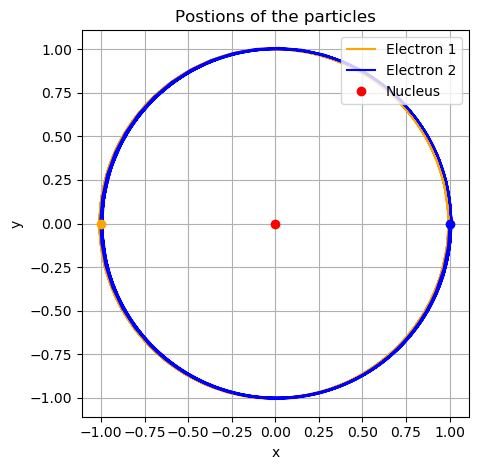

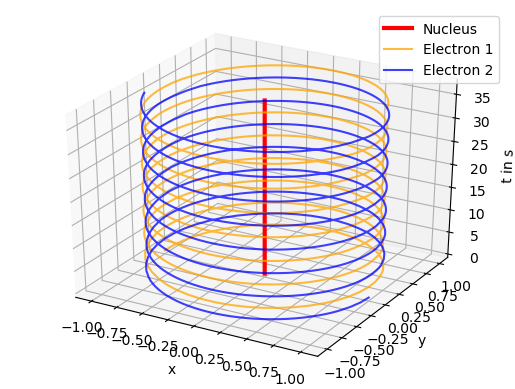

In [25]:
data2 = helium(-1, 0, 1, 0, 0, np.sqrt(1.75), 0, -
               np.sqrt(1.75), .1, 2000, True, eulerrich)
plot2(data2[0][:, 0], data2[0][:, 1],data2[1][:, 0],data2[1][:, 1],"Electron 1","Electron 2")
plot3d(data2[0][:, 0], data2[0][:, 1], data2[1][:, 0],
       data2[1][:, 1], data2[4], data2[2], "Electron 1", "Electron 2", "Nucleus")

Using the Euler-Richardson Algorithm the results agree with the analytical solution and the two electrons have a circular orbit around the nucleus.


Another test can be to observe the energie in the system. The total energy should always stay constant since it is a conservative system. This can be checked by plotting the different energies of the system.

For the analytically solved problem one can see that the energies do vary a little but the total energy is conserved.

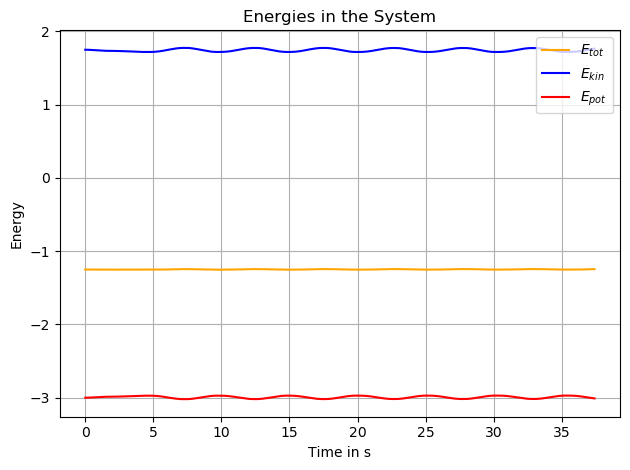

In [26]:
plotE(data2[5][:,0],data2[5][:,1],data2[5][:,2],data2[4])

For the example given in the assignment, the energy is converted more frequently and the total energy also ocillates slightly. This is because one of the electrons orbits really close to the nucleus and the timestep has to be chosen very small.
There will be a lot of timesteps and the change in energy of all these timesteps accumulates.

Since the number of iterations was very large the curves overlap and make it seem like they were areas.

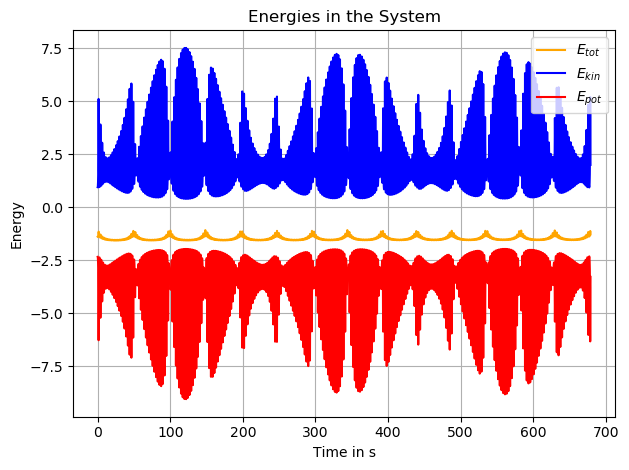

In [27]:
plotE(data[5][:,0],data[5][:,1],data[5][:,2],data[4])

Since the number of iterations was very large the curves overlap and make it seem like they were areas.
With less iterations the graph is more clear:

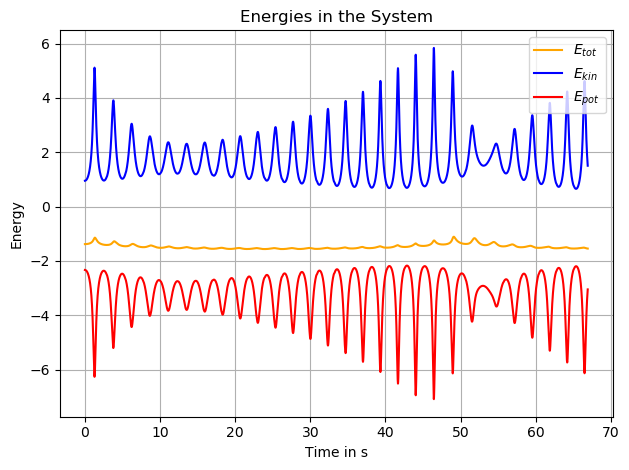

In [28]:
data3 = helium(2, 0, -1, 0, 0, .95, 0, -1, .1, 100000, True, eulerrich)
plotE(data3[5][:,0],data3[5][:,1],data3[5][:,2],data3[4])

Over many iterations the numerical algorithms will fail to conserve the energy since the accuarcy is not very high.
This could be countered by changing the timestep control to allow even smaller changes in energy from one iteration to the other but the time step would then be extremely small and longer simulations would be very costly.